# Models presented in the paper
## Preamble
In the following section we present the main functions and data used in this notebook
### Evaluate
The evaluate function serves to compute the different tax base used in order to test the intercompany transaction

In [1]:
function evaluate(base,fun,fcost,vcost,N,P) 
    if fun == "manufacturer"
        return (fcost + (N*vcost))
    elseif fun == "distributor"
        return (N*P)
    else
        return base
    end
end

evaluate (generic function with 1 method)

### Robustify

The robustify function serves as a function to allow for higher penalty in order to implement the robust goal programming in a worst-case scenario environment 

In [2]:
function robustify(coefficients, deviation)
    return convert(Matrix,coefficients) .* convert(Matrix,deviation)
end

robustify (generic function with 1 method)

### Packages used
The following packages where used

In [3]:
using CSV;
using DataFrames;
using Plots; pyplot();

In [4]:
using vOptGeneric;
using JuMP;

In [5]:
using Clp;
using GLPK;
using GLPKMathProgInterface;
using Ipopt;

for most of the graphics

In [6]:
using RCall

## Data used

In [7]:
dt = CSV.read("data/overall.csv");
dtf = CSV.read("data/entities.csv"); #fetch the data from the .csv
dtfdev = CSV.read("data/deviations.csv"); #fetch the data from the .csv

dt contains

In [8]:
dt

,nitems,price,taxgoal
,Float64,Float64,Float64
1,1.0e6,61.2,0.1


dtf contains

In [9]:
dtf

,id,function,base,tax,vcost,fcost,duties,mgoal,lquartile
,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,manufacturer,0.0,0.25,23.75,811800.0,0.15,3.2,0.04
2,2,distributor,0.0,0.3,11.3,35700.0,0.0,2.8,0.01
3,3,principal,6.759e7,0.125,16.8,171000.0,0.0,5.1,0.02


dtfdev contains

In [10]:
dtfdev

,id,tax,duties,lquartile,median,uquartile
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,0.05,0.5,0.15,0.15,0.15
2,2,0.1,0.0,0.12,0.12,0.12
3,3,0.2,0.0,0.21,0.21,0.21


From the data files we get the variables as below

In [11]:
q = size(dtf)[1]; #number of decision variables

In [12]:
N     = dt[:,:nitems][1]; #number of pieces
P     = dt[:,:price][1]; #price
tgoal = dt[:,:taxgoal][1];

In [13]:
tax    = dtf[:,:tax];
fun    = dtf[:,:function];
base   = dtf[:,:base];
fcost  = dtf[:,:fcost];
vcost  = dtf[:,:vcost];
lq     = dtf[:,:lquartile];
mq     = dtf[:,:median];
uq     = dtf[:,:uquartile];
mgoal  = dtf[:,:mgoal];
duties = dtf[:,:duties];

more specifically

In [14]:
rbi = filter(x -> x != :id, names(dtfdev)); #create the index of the robust coefficients

θ = robustify(dtf[:,rbi],dtfdev[:,rbi]);
δ = 2.50;
tgoal = ((N*P)-sum(((fcost)+(N.*vcost)).*(ones(3) + duties)))*tgoal;


for i = 1:q #create the BASE
    base[i] = evaluate(base[i],fun[i],fcost[i],vcost[i],N,P)
end

The coefficients subject to robustness are highlithed below 

In [15]:
rbi

5-element Array{Symbol,1}:
 :tax      
 :duties   
 :lquartile
 :median   
 :uquartile

result of the robustification (noise matrix in the paper)

In [16]:
θ

3×5 Array{Float64,2}:
 0.0125  0.075  0.006   0.012   0.021 
 0.03    0.0    0.0012  0.0024  0.006 
 0.025   0.0    0.0042  0.0147  0.0294

The tax base minimization objective

In [17]:
tgoal

464723.0

The different base where to test the arm's lenght transaction

In [18]:
base

3-element Array{Float64,1}:
 2.45618e7
 6.12e7   
 6.759e7  

first parametrization

In [19]:
w = (0.25,0.5,0.25); #weight vector
ρ = (0.0,0.0,0.0); #robustness vector

### Data used in weight and robust sensitivity

Rhocb contains the combination of the robust parameter used for the robust sensitivity analysis

In [20]:
rhocb = CSV.read("data/rho_permutations.csv");
rhocb = convert(Matrix{Float64},rhocb)

64×3 Array{Float64,2}:
 0.0  0.0  0.0
 0.0  0.0  1.0
 0.0  0.0  2.0
 0.0  0.0  3.0
 0.0  1.0  0.0
 0.0  1.0  1.0
 0.0  1.0  2.0
 0.0  1.0  3.0
 0.0  2.0  0.0
 0.0  2.0  1.0
 0.0  2.0  2.0
 0.0  2.0  3.0
 0.0  3.0  0.0
 ⋮            
 3.0  1.0  0.0
 3.0  1.0  1.0
 3.0  1.0  2.0
 3.0  1.0  3.0
 3.0  2.0  0.0
 3.0  2.0  1.0
 3.0  2.0  2.0
 3.0  2.0  3.0
 3.0  3.0  0.0
 3.0  3.0  1.0
 3.0  3.0  2.0
 3.0  3.0  3.0

w contains the combinations of weights used for the weight sensitivity analysis

In [21]:
### Weight sensitivity ###
w_sense = CSV.read("data/weight-sense.csv");
w_sense = w_sense[:,2:4];
n = nrow(w_sense);

w_sense = convert(Matrix{Float64},w_sense)

21×3 Array{Float64,2}:
 0.0        0.5        0.5      
 0.166667   0.416667   0.416667 
 0.333333   0.333333   0.333333 
 0.5        0.25       0.25     
 0.666667   0.166667   0.166667 
 0.833333   0.0833333  0.0833333
 1.0        0.0        0.0      
 0.5        0.0        0.5      
 0.416667   0.166667   0.416667 
 0.333333   0.333333   0.333333 
 0.25       0.5        0.25     
 0.166667   0.666667   0.166667 
 0.0833333  0.833333   0.0833333
 0.0        1.0        0.0      
 0.5        0.5        0.0      
 0.416667   0.416667   0.166667 
 0.333333   0.333333   0.333333 
 0.25       0.25       0.5      
 0.166667   0.166667   0.666667 
 0.0833333  0.0833333  0.833333 
 0.0        0.0        1.0      

## Lexicographic model
In the following section we present the Lexichographic model used in the experiment section in the paper.
We init the model using the vOptGeneric framework.

In [22]:
m = vModel(solver = GLPKSolverMIP());

We define the deviational variables and their conditions, namely:
* dt are the deviations on tax minimization objective;
* df are the deviations on transfer pricing objective;
* dm are the deviations on management objective.

In [23]:
@variables m begin #init the deviational variables
    dt[1:1,1:2] >= 0
    df[1:q,1:2] >= 0
    dm[1:q,1:2] >= 0
end

In [24]:
@variable(m, x[1:q] >= 0); #init the decision variable

In [25]:
@addobjective(m, Min,sum(dt./tgoal));
@addobjective(m, Min,sum(df./mq));
@addobjective(m, Min,sum(dm./mgoal));

In [26]:
#Soft constraints
@constraint(m, N*(sum(x.*tax)) - dt[1,1] == tgoal); #tax minimization goal
@constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq); #median seeker
@constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #management's goal

In [27]:
#Hard constraints
@constraint(m, N.*(x./base) .>= lq); #lower quartile constraints
@constraint(m, N.*(x./base) .<= uq); #upper quartile constraints

In [28]:
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) >= P); #final price condition
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) <= P + δ);

The model writes as (the objective printing is bugged in vOptGeneric)

In [29]:
m

Feasibility problem with:
 * 15 linear constraints
 * 17 variables
Solver is GLPKMathProgInterface.GLPKInterfaceMIP.GLPK

In [30]:
solve( m, method = :lex)

solving for objectives [1, 2, 3]
solving for objectives [1, 3, 2]
solving for objectives [2, 1, 3]
solving for objectives [2, 3, 1]
solving for objectives [3, 1, 2]
solving for objectives [3, 2, 1]


:Optimal

In [31]:
printX_E(m)

[0.506821, 1.54171, 3.95075] : dt[1,1]=235531.27777777857 df[1,2]=0.04 df[2,2]=0.010000000000000005 df[3,2]=0.037919955285956077 dm[1,1]=0.9824719999999998 dm[1,2]=3.2 dm[2,1]=0.612 dm[2,2]=2.8 dm[3,1]=2.168290222222229 dm[3,2]=5.1 x[1]=0.9824719999999999 x[2]=0.6119999999999998 x[3]=2.168290222222229 
[1.50026, 0.486837, 2.34703] : dt[1,1]=697204.1728536466 df[2,2]=2.8528445241156354e-8 df[3,2]=0.03407850905330359 dm[1,2]=1.2350560000000004 dm[2,1]=1.223998254059151 dm[2,2]=2.8 dm[3,2]=2.6720664269127896 x[1]=1.9649439999999998 x[2]=1.223998254059151 x[3]=2.42793357308721 


In [32]:
vOptGeneric.getvalue(x,1)

3-element Array{Float64,1}:
 0.9824719999999999
 0.6119999999999998
 2.168290222222229 

## Weighted GP not robust
In the following section we present the non robust model used in the experiment section in the paper.

In [33]:
w = (0.25,0.5,0.25); #weight vector

In [34]:
m = Model(solver = ClpSolver());

In [35]:
@variables m begin #init the deviational variables
    dt[1:1,1:2] >= 0
    df[1:q,1:2] >= 0
    dm[1:q,1:2] >= 0
end

In [36]:
@variable(m, x[1:q] >= 0); #init the decision variable

In [37]:
@objective(m, Min, (w[1]*sum(dt./tgoal)
           + w[2]*sum(df./mq)
           + w[3]*sum(dm./mgoal)
           )); #obj function

In [38]:
#Soft constraints
@constraint(m, N*(sum(x.*tax)) - dt[1,1] == tgoal); #tax minimization goal
@constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq); #median seeker
@constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #management's goal

In [39]:
#Hard constraints
@constraint(m, N.*(x./base) .>= lq); #lower quartile constraints
@constraint(m, N.*(x./base) .<= uq); #upper quartile constraints

In [40]:
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) >= P); #final price condition
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) <= P + δ);

In [41]:
m

Minimization problem with:
 * 15 linear constraints
 * 17 variables
Solver is Clp

In [42]:
status = solve(m)

:Optimal

In [43]:
solution=JuMP.getvalue(x);
print(solution)

[1.96494, 1.224, 2.42793]

## Robust Weighted GP
In the following section we present the robust model used in the experiment section in the paper.

In [169]:
w = (0.25,0.5,0.25); #weight vector
ρ = (3.0,3.0,3.0); #robustness vector

In [170]:
m = Model(solver = ClpSolver());

In [171]:
@variables m begin #init the variables
    dt[1:1,1:2] >= 0
    df[1:q,1:2] >= 0
    dm[1:q,1:2] >= 0
    π[1:q,1:2] >= 0
    ζ[1:2] >= 0
    x[1:q] >= 0
end

In [172]:
@objective(m, Min, (w[1]*sum(dt./tgoal))
           + (w[2]*sum(df./mq))
           + (w[3]*sum(dm./mgoal))
           ); #obj function

In [173]:
@constraint(m, N*(sum(x.*tax)) + sum(π[:,1]) + (ρ[1]*ζ[1]) - dt[1,1] == tgoal); #obj 1

@constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq - ((θ[:,4]./q).*ρ[2])); #obj 2

@constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #obj 3

for i=1:q #create the robust constraint for obj 1 and con 1
    @constraint(m,ζ[1]+π[i,1] >= θ[i,1]*x[i]);
    @constraint(m,ζ[2]+π[i,2] >= θ[i,2]*x[i]);
end

for i=0:ρ[2] #create the robust constraint for obj 2
    @constraint(m, N.*(x./base) .>= lq - ((θ[:,3]./q).*i));
    @constraint(m, N.*(x./base) .<= uq - ((θ[:,5]./q).*i));
end

@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) >= P) #final price condition
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) <= P + δ);

In [174]:
m

Minimization problem with:
 * 39 linear constraints
 * 25 variables
Solver is Clp

In [175]:
status = solve(m)

:Optimal

In [176]:
solution=JuMP.getvalue(x);
print(solution)

[1.6702, 1.07712, 2.86293]

# Sensitivity analysis

## Weight sensitivity analysis

In [52]:
ρ = (3.0,3.0,3.0); #robustness vector

In [53]:
n = length(w_sense[:,1])

res = DataFrame(X1 = Float64[],X2 = Float64[],X3 = Float64[]);

j = 1;

for j = 1:n

    m = Model(solver = ClpSolver());

    @variables m begin #init the variables
        dt[1:1,1:2] >= 0
        df[1:q,1:2] >= 0
        dm[1:q,1:2] >= 0
        π[1:q,1:2] >= 0
        ζ[1:2]>=0
        x[1:q] >= 0
    end

    @objective(m, Min, (w_sense[j,1]*sum(dt./tgoal))
               + (w_sense[j,2]*sum(df./mq))
               + (w_sense[j,3]*sum(dm./mgoal))
               ); #obj function


    @constraint(m, N*(sum(x.*tax)) + sum(π[:,1]) + (ρ[1]*ζ[1]) - dt[1,1] == tgoal); #obj 1

    @constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq - ((θ[:,4]./q).*ρ[2])); #obj 2

    @constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #obj 3

    for i=1:q #create the robust constraint for obj 1 and con 1
        @constraint(m,ζ[1]+π[i,1] >= θ[i,1]*x[i]);
        @constraint(m,ζ[2]+π[i,2] >= θ[i,2]*x[i]);
    end

    for i=0:ρ[2] #create the robust constraint for obj 2
        @constraint(m, N.*(x./base) .>= lq - ((θ[:,3]./q).*i));
        @constraint(m, N.*(x./base) .<= uq - ((θ[:,5]./q).*i));
    end

    @constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) >= P) #final price condition
    @constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) <= P + δ);

    status = solve(m);

    b = JuMP.getvalue(x);
    pi = JuMP.getvalue(π);
    z = JuMP.getvalue(ζ);

    push!(res, JuMP.getvalue(x));

end

In [54]:
res

,X1,X2,X3
,Float64,Float64,Float64
1,1.6702,1.07712,2.86293
2,1.6702,1.07712,2.86293
3,1.6702,1.07712,2.86293
4,0.982472,0.612,1.3518
5,0.982472,0.612,1.3518
6,0.982472,0.612,1.3518
7,0.982472,0.612,1.3518
8,0.982472,0.612,1.3518
9,0.982472,1.07712,3.73773


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = sexp(::Type{RCall.RClass{:list}}, ::DataFrame) at dataframe.jl:25
└ @ RCall /home/mrepetto94/.julia/packages/RCall/iojZI/src/convert/dataframe.jl:25
┌ Warning: RCall.jl: Carico il pacchetto richiesto: ggplot2
│ Registered S3 methods overwritten by 'ggtern':
│   method           from   
│   +.gg             ggplot2
│   grid.draw.ggplot ggplot2
│   plot.ggplot      ggplot2
│   print.ggplot     ggplot2
│ --
│ Remember to cite, run citation(package = 'ggtern') for further info.
│ --
│ 
│ Attaching package: ‘ggtern’
│ 
│ The following objects are masked from ‘package:ggplot2’:
│ 
│     %+%, aes, annotate, calc_element, ggplot, ggplot_build,
│     ggplot_gtable, ggplotGrob, ggsave, layer_data, theme, theme_bw,
│     theme_classic, theme_dark, theme_gray, theme_light, theme_linedraw,
│     theme_minimal, theme_void
│ 
└ @ RCall /home/mrepetto94/.julia/packages/RCall/iojZI/src/i

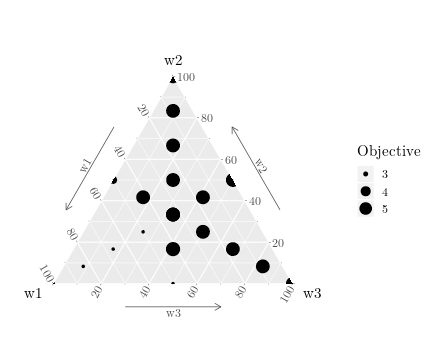

RObject{VecSxp}


In [55]:
R"library(ggtern)

central = seq(0, 1, length.out=7)
sides = (1 - central)/2

w1 = c(central,sides,sides)
w2 = c(sides,central,sides)
w3 = c(sides,sides,central)

obj = apply($res, 1, sum)

df = data.frame(w1,w2,w3, obj)

ggtern(data = df, aes(x=w1,y=w2,z=w3, size=obj)) + 
    geom_point() + 
    theme_showarrows() + 
    theme(text= element_text(size=15, family=\"LM Roman 10\")) + 
    scale_size_continuous(name=\"Objective\")
"

## Robust sensitivity analysis

In [56]:
w = (0.25,0.5,0.25); #weight vector

In [57]:
n = length(rhocb[:,1])

res = DataFrame(X1 = Float64[],X2 = Float64[],X3 = Float64[]);

j = 1;

for j = 1:n

    m = Model(solver = ClpSolver());

    @variables m begin #init the variables
        dt[1:1,1:2] >= 0
        df[1:q,1:2] >= 0
        dm[1:q,1:2] >= 0
        π[1:q,1:2] >= 0
        ζ[1:2]>=0
        x[1:q] >= 0
    end

    @objective(m, Min, (w[1]*sum(dt./tgoal))
               + (w[2]*sum(df./mq))
               + (w[3]*sum(dm./mgoal))
               ); #obj function


    @constraint(m, N*(sum(x.*tax)) + sum(π[:,1]) + (rhocb[j,1]*ζ[1]) - dt[1,1] == tgoal); #obj 1

    @constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq - ((θ[:,4]./q).*rhocb[j,2])); #obj 2

    @constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #obj 3

    for i=1:q #create the robust constraint for obj 1 and con 1
        @constraint(m,ζ[1]+π[i,1] >= θ[i,1]*x[i]);
        @constraint(m,ζ[2]+π[i,2] >= θ[i,2]*x[i]);
    end

    for i=0:rhocb[j,2] #create the robust constraint for obj 2
        @constraint(m, N.*(x./base) .>= lq - ((θ[:,3]./q).*i));
        @constraint(m, N.*(x./base) .<= uq - ((θ[:,5]./q).*i));
    end

    @constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (rhocb[j,3]*ζ[2]) >= P) #final price condition
    @constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (rhocb[j,3]*ζ[2]) <= P + δ);

    status = solve(m);

    b = JuMP.getvalue(x);
    pi = JuMP.getvalue(π);
    z = JuMP.getvalue(ζ);

    push!(res, JuMP.getvalue(x));

end

In [58]:
res

,X1,X2,X3
,Float64,Float64,Float64
1,1.96494,1.224,2.42793
2,1.96494,1.224,2.29694
3,1.96494,1.224,2.29694
4,1.96494,1.224,2.29694
5,1.8667,1.17504,2.61005
6,1.8667,1.17504,2.4856
7,1.8667,1.17504,2.4856
8,1.8667,1.17504,2.4856
9,1.76845,1.12608,2.79216


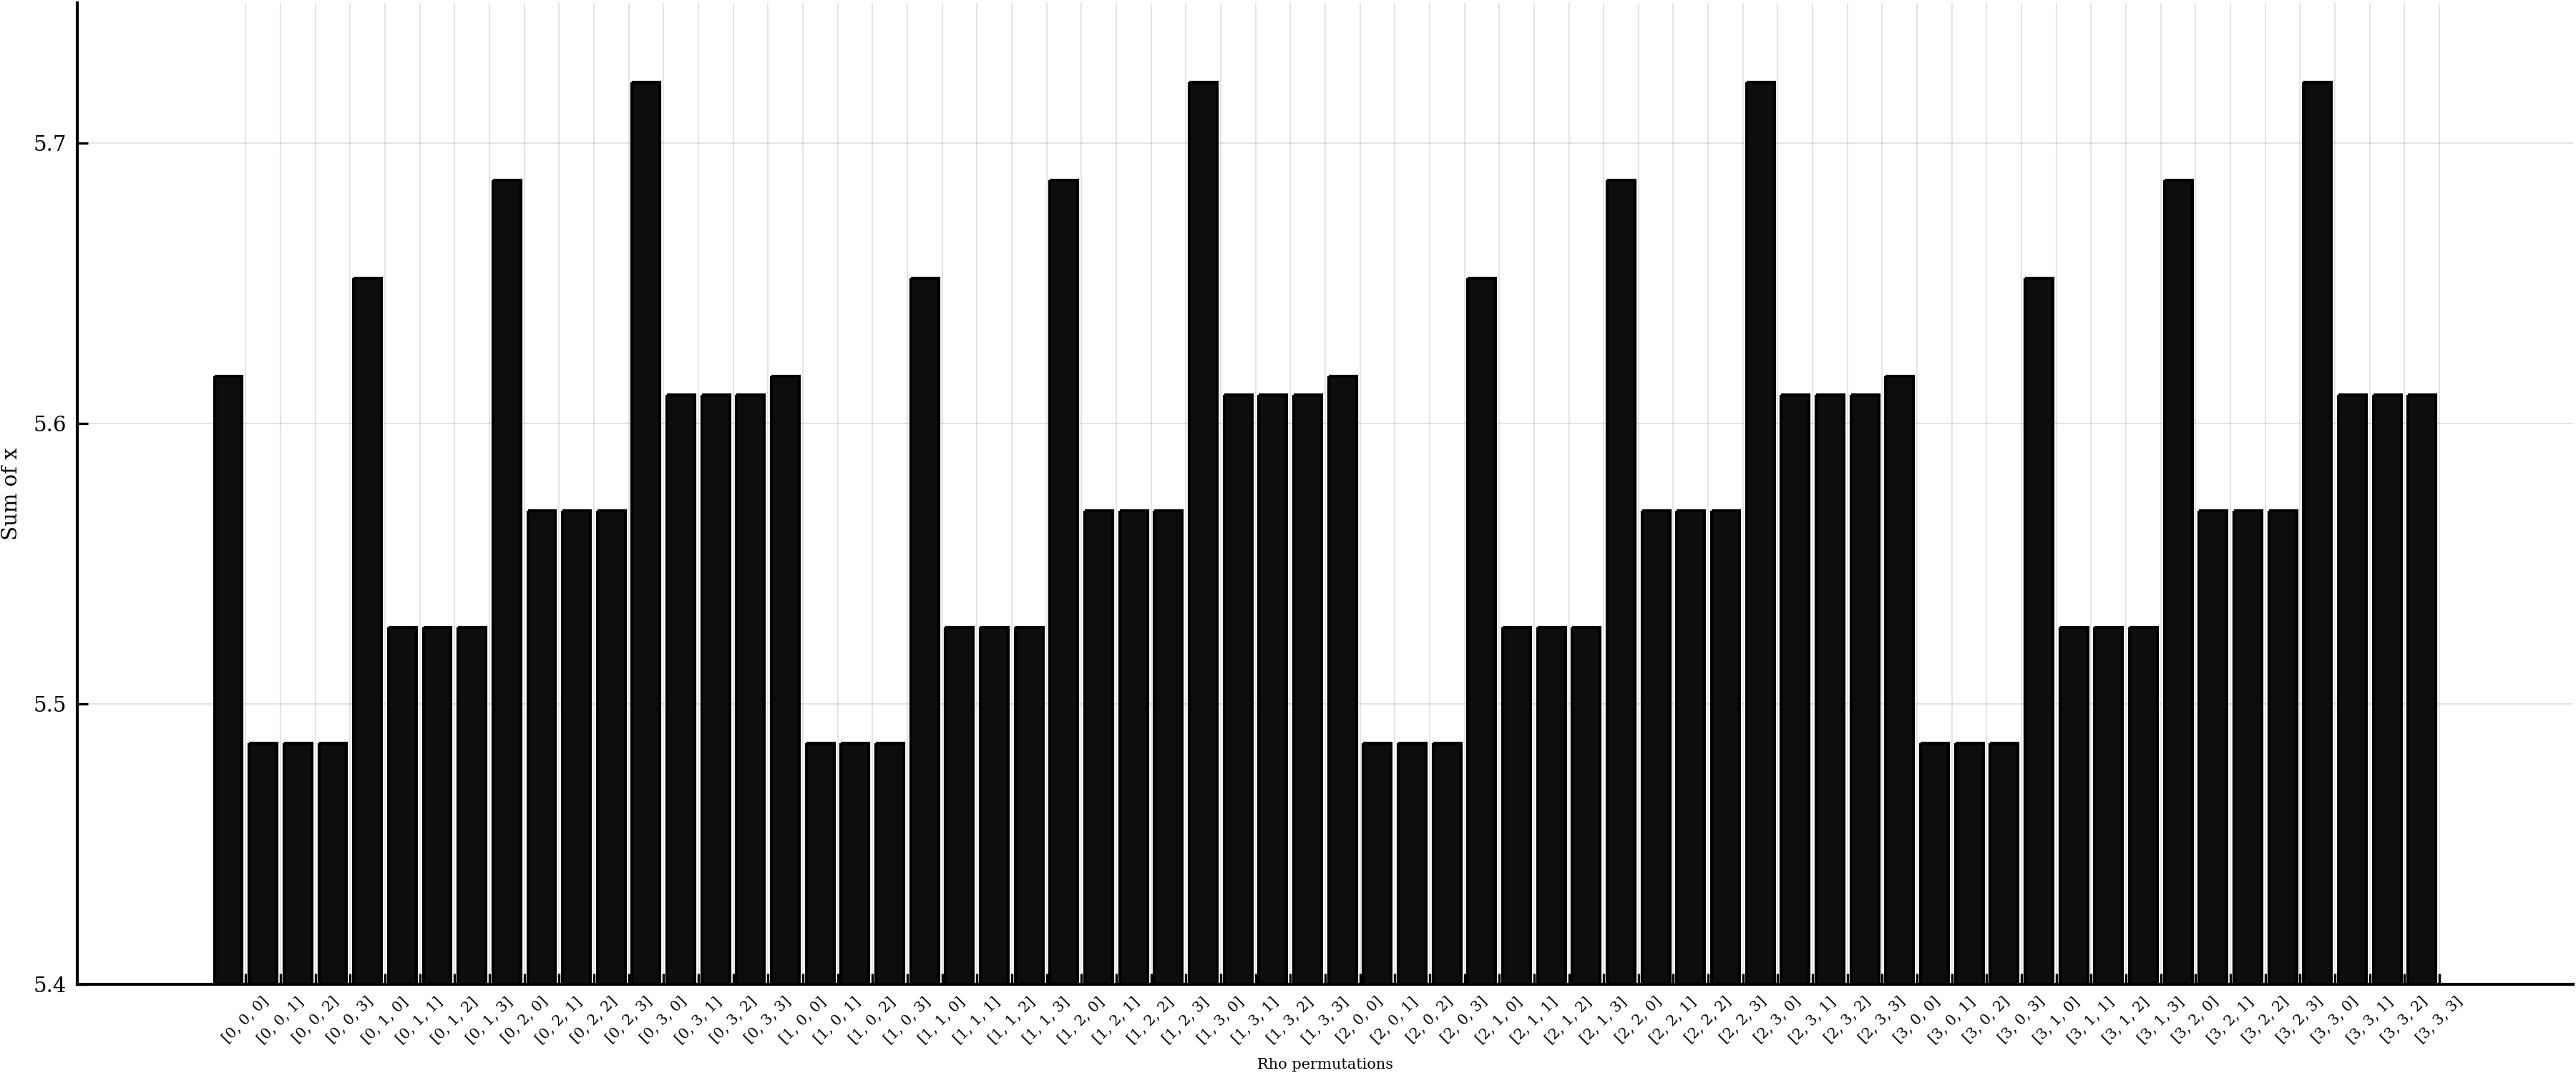

In [92]:
resu = convert(Matrix{Float64},res);
df = convert(Matrix{Int},rhocb);

sresu= sum(resu, dims=2);
xs = [string(df[i,:]) for i = 1:64];

Plots.plot(xs,sresu,xrotation=45,seriestype=:bar,dpi=300,ylims = (5.4,5.75),yaxis=("Sum of x", font(7, "serif")), xaxis=("Rho permutations", font(5, "serif")), palette = (:grays), lab = "", xticks = (1:64,xs), size = (1200,500),fmt = :png)

# Robust Weight Goal Programming model with Satisfaction Function

## Satisfaction function
In the model we use a satisfaction function of the form:
$$
F(\delta) = e^\frac{-\delta^2}{ 2 \sigma^2}
$$

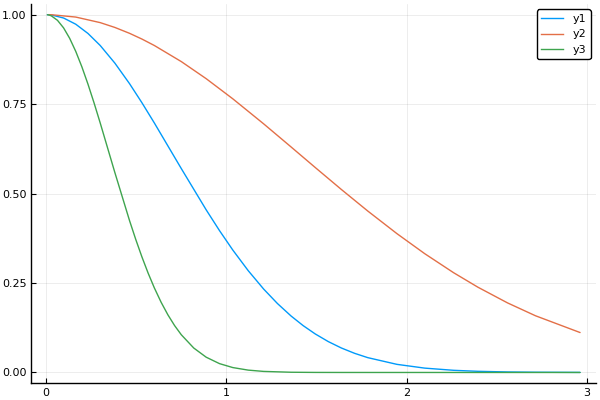

In [297]:
f(x) = exp(-x^2/1^2)
k(x) = exp(-x^2/2^2)
z(x) = exp(-x^2/(0.5)^2)
Plots.plot([f,k,z], 0, 3)

In [299]:
w = (0.25,0.5,0.25); #weight vector
ρ = (3.0,3.0,3.0); #robustness vector

In [286]:
m = Model(solver = IpoptSolver());

In [287]:
@variables m begin #init the variables
    dt[1:1,1:2] >= 0
    df[1:q,1:2] >= 0
    dm[1:q,1:2] >= 0
    π[1:q,1:2] >= 0
    ζ[1:2] >= 0
    x[1:q] >= 0
end

In [288]:
JuMP.register(m,:f, 1, f, autodiff=true)

In [300]:
@NLobjective(m, Max, (w[1]*f(dt[1,1]/tgoal))
           + (w[2]*f((df[1,1]+df[1,2])/mq[1] + (df[2,1]+df[2,2])/mq[2] + (df[3,1]+df[3,2])/mq[3]))
           + (w[3]*f((dm[1,1]+dm[1,2])/mgoal[1] + (dm[2,1]+dm[2,1])/mgoal[2] +(dm[3,1]+dm[3,2])/mgoal[3]))
           ); #obj function

In [301]:
@constraint(m, N*(sum(x.*tax)) + sum(π[:,1]) + (ρ[1]*ζ[1]) - dt[1,1] == tgoal); #obj 1

@constraint(m, (N.*(x./base)) + ((df.* transpose([-1,1]))*[1,1]).== mq - ((θ[:,4]./q).*ρ[2])); #obj 2

@constraint(m, x + ((dm.* transpose([-1,1]))*[1,1]) .== mgoal); #obj 3

for i=1:q #create the robust constraint for obj 1 and con 1
    @constraint(m,ζ[1]+π[i,1] >= θ[i,1]*x[i]);
    @constraint(m,ζ[2]+π[i,2] >= θ[i,2]*x[i]);
end

for i=0:ρ[2] #create the robust constraint for obj 2
    @constraint(m, N.*(x./base) .>= lq - ((θ[:,3]./q).*i));
    @constraint(m, N.*(x./base) .<= uq - ((θ[:,5]./q).*i));
end

@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) >= P) #final price condition
@constraint(m, sum((vcost + fcost./N + ((x).*(ones(3)+tax))).*(ones(3)+duties)) + sum(π[:,2]) + (ρ[3]*ζ[2]) <= P + δ);

In [302]:
m

Maximization problem with:
 * 78 linear constraints
 * 25 variables
Solver is Ipopt

In [303]:
status = solve(m)

:Optimal

In [304]:
solution=JuMP.getvalue(x);
print(solution)

[1.36136, 1.04873, 1.97254]